In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

with open("configurations/Run001213.yaml", 'r') as stream:
    cfg = yaml.safe_load(stream)

In [2]:
stream_df = pd.read_csv('data/data_000001.txt')
stream_df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,2,0,63,2252311494,3144,10.0
1,2,0,62,2252311494,3148,8.0
2,2,1,13,2252311502,2214,8.0
3,2,1,88,2252311509,945,5.0
4,2,1,116,2252311530,1582,29.0


In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
from modules.mappings import Mapping

# create a dataframe with only valid hits ->
# trigger words and scintillator hits are removed
hits_df = stream_df[
    (stream_df.HEAD == cfg['headers']['valid_hit']) &
    (stream_df.TDC_CHANNEL <= 127)
    ].copy()

# fix TDC_MEAS data type
hits_df = hits_df.astype({'TDC_MEAS': 'int32'})

# create mapping with the loaded configurations
mapper = Mapping(cfg)

# map hits
hits_df = mapper.global_map(hits_df)
hits_df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,SL,LAYER,TDC_CHANNEL_NORM,WIRE_NUM,WIRE_X_LOC,WIRE_Z_LOC,WIRE_Z_GLOB,WIRE_X_GLOB
0,2,0,63,2252311494,3144,10,0,1,63,16,336.0,-19.5,200.3,336.0
1,2,0,62,2252311494,3148,8,0,3,62,16,336.0,6.5,226.3,336.0
2,2,1,13,2252311502,2214,8,2,2,13,4,-189.0,-6.5,1029.1,-189.0
3,2,1,88,2252311509,945,5,3,4,24,7,-63.0,19.5,1839.3,-63.0
4,2,1,116,2252311530,1582,29,3,4,52,14,231.0,19.5,1839.3,231.0


In [6]:
USE_SCINT = True 

# select all orbits with a trigger signal from
# the scintillators coincidence
if USE_SCINT:
    # select all hits in the stream from the scintillator channel
    trigger_df = stream_df[
        (stream_df['HEAD'] == cfg['scintillator']['head']) & 
        (stream_df['FPGA'] == cfg['scintillator']['fpga']) & 
        (stream_df['TDC_CHANNEL'] == cfg['scintillator']['tdc_ch'])
    ].copy()
else:
    # use the time from the neural network -> select one FPGA since 
    # there is a macrocell running in both FPGAs
    trigger_df = stream_df[
        (stream_df['HEAD'] == cfg['headers']['t0_trg']) & 
        (stream_df['FPGA'] == 0)
    ].copy()

# create a T0 column (in ns)
trigger_df['T0'] = (trigger_df['BX_COUNTER'] + trigger_df['TDC_MEAS'] / 30)

# join trigger table to the dataframe with valid hits
hits_df_ = pd.merge(
        hits_df, trigger_df[['ORBIT_CNT','T0']],
        left_on='ORBIT_CNT', right_on='ORBIT_CNT',
        suffixes=(None, None)
    )

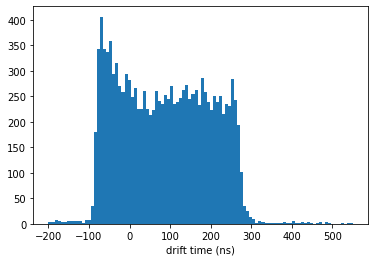

In [9]:
plt.hist(
    ((hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30) - hits_df_['T0'])*25,
    range=(-200,550), bins=100
    )
plt.xlabel('drift time (ns)')
plt.show()

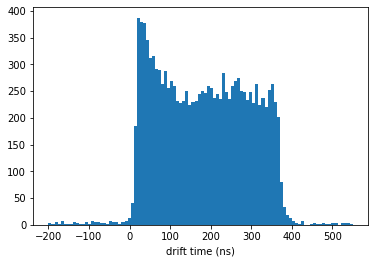

In [11]:
from modules.constants import *

# apply scintillator calibration -> they shoul be computed
# for each run! For this example run, values are provided in
# the configurations file.

# create a time column in NS
hits_df_['T0_NS'] = hits_df_['T0'] * DURATION_BX

if USE_SCINT:
    for sl, offset_sl in cfg['time_offset_sl'].items():
        # correction is in the form:
        # coarse offset valid for all SL + fine tuning 
        hits_df_.loc[
            hits_df_['SL'] == sl, 'T0_NS'
        ] -= cfg['time_offset_scint'] + offset_sl

    # draw the new time box -> the rising edge should be in 0
    plt.hist(
        ((hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30))*25-hits_df_['T0_NS'],
        range=(-200,550), bins=100
        )
    plt.xlabel('drift time (ns)')
    plt.show()

In [12]:
def map_hit_position(df, local=False):
    """
    Compute the position of the hit.
    If local=True the positions left/right will 
    be computed in the local frame of reference
    (e.g. X_LEFT_LOC). Else, the positions will be
    computed in the global frame of reference
    """

    hits_df_['HIT_DRIFT_TIME'] = (hits_df_['BX_COUNTER']+hits_df_['TDC_MEAS']/30)*25-hits_df_['T0_NS']

    if local:
        ref = 'LOC'
    else:
        ref = 'GLOB'

    hits_df_[f'X_LEFT_{ref}'] = hits_df_[f'WIRE_X_{ref}'] - hits_df_['HIT_DRIFT_TIME']*VDRIFT
    hits_df_[f'X_RIGHT_{ref}'] = hits_df_[f'WIRE_X_{ref}'] + hits_df_['HIT_DRIFT_TIME']*VDRIFT

    return hits_df_

In [13]:
# having the time allows us to compute hit position 
# with left / right ambiguity

hits_df_ = map_hit_position(hits_df_, local=False)

In [14]:
cfg['sl_view']

{0: 'phi', 1: 'theta', 2: 'phi', 3: 'phi'}

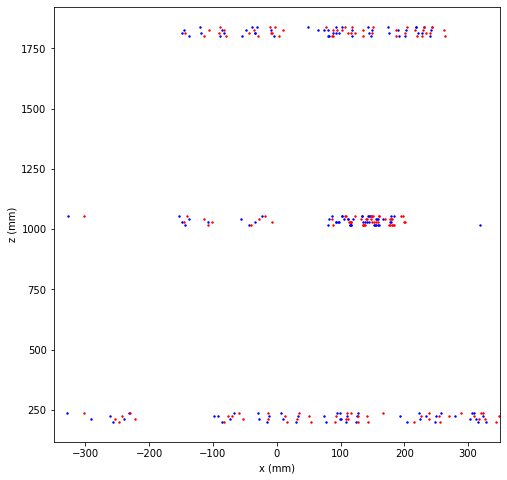

In [15]:
# plot first 50 hits for each SL
plt.figure(figsize=(8, 8))

for sl in range(4):
    # plot sl with PHI view
    if cfg['sl_view'][sl] != 'phi':
        continue
    curr_sl = hits_df_[hits_df_.SL==sl][:50]
    plt.scatter(curr_sl.X_LEFT_GLOB, curr_sl.WIRE_Z_GLOB, s=2, color='blue')
    plt.scatter(curr_sl.X_RIGHT_GLOB, curr_sl.WIRE_Z_GLOB, s=2, color='red')

plt.xlim(-350, 350)
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.show()